In [ ]:
# pip install pingouin

In [51]:
# import necessary packages

import pandas as pd
import itertools
import numpy as np
import scipy.stats
from scipy.stats import ks_2samp
from statsmodels.stats.weightstats import ztest as ztest
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import networkx as nx
from random import randint

import math
# import pingouin as pg

import warnings
warnings.filterwarnings("ignore")

In [11]:
# import necessary data

# result = pd.read_csv("/Users/robinkong/codes/result.csv")
paperdata = pd.read_csv("/Users/robinkong/codes/paperdata.csv")
cb = pd.read_csv("/Users/robinkong/codes/citationBara.csv")
primdata = pd.read_csv("/Users/robinkong/codes/primdata.csv")
# pair = pd.read_csv("/Users/robinkong/codes/pairs.csv", chunksize = 1000000)
# mfpairs = pd.read_csv("/Users/robinkong/codes/mfpairs.csv")
# sim_mf = pd.read_csv("/Users/robinkong/codes/mfpairs_similarity.csv")

# Statistical Analyses

## Basic Statistics

In [144]:
print("Total papers: ", result.doi.nunique())
print("Papers with gender info: ", paperdata.doi.nunique())
print("Papers with primary gender info: ", primdata.doi.nunique())

Total papers:  541448
Papers with gender info:  375738
Papers with primary gender info:  273020


In [145]:
# journal query condition

s = "PRL"

print(f"Total {s} papers: ", result[result['journal'] == s].doi.nunique())
print(f"{s} papers with gender info: ", paperdata[paperdata['journal'] == s].doi.nunique())

df = primdata[primdata['journal'] == s]

print(f"{s} papers with primary gender info: ", df.doi.nunique())
print(f"{s} papers written primarily by men: ", len(df[df['gender']=='male']))
print(f"{s} papers written primarily by women: ", len(df[df['gender']=='female']))

Total PRL papers:  110080
PRL papers with gender info:  76527
PRL papers with primary gender info:  54460
PRL papers written primarily by men:  48950
PRL papers written primarily by women:  5510


In [156]:
# PACS query condition

pacs = '90'

print(f"Total PACS{pacs} papers: ", result[result[f'pacs{pacs}'] == 1].doi.nunique())
print(f"PACS{pacs} papers with gender info: ", paperdata[paperdata[f'pacs{pacs}'] == 1].doi.nunique())

df = primdata[primdata[f'pacs{pacs}'] == 1]

print(f"PACS{pacs} papers with primary gender info: ", df.doi.nunique())
print(f"PACS{pacs} papers written primarily by men: ", len(df[df['gender']=='male']))
print(f"PACS{pacs} papers written primarily by women: ", len(df[df['gender']=='female']))

Total PACS90 papers:  26601
PACS90 papers with gender info:  12628
PACS90 papers with primary gender info:  9597
PACS90 papers written primarily by men:  8469
PACS90 papers written primarily by women:  1128


### Participation Growth

In [6]:
# Observe number of authors by year, separated by gender

tdata = paperdata.copy()
tdata.sort_values("id", inplace = True)
tdata.drop_duplicates(subset = ["id", "year"],
                         keep = "first", inplace = True)

m_tdata = tdata[tdata['gender'] == 'male'].groupby(['year'])['year'].count()
w_tdata = tdata[tdata['gender'] == 'female'].groupby(['year'])['year'].count()

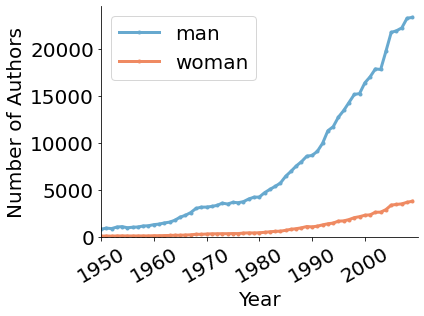

In [12]:
# Year vs. Number of Authors (Plot)

# Regular graph format throughout this paper
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Male authors
m_tdata.plot(style='.-',color='#67a9cf', lw=3)
# Female authors
w_tdata.plot(style='.-',color='#ef8a62', lw=3)

plt.legend(('man', 'woman'), loc='upper left', fontsize=20)
plt.xticks(np.arange(1950, 2010, step=10), fontsize=20, rotation=30)
plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1950, xmax=2010)
plt.ylabel('Number of Authors', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/Fig_1A.pdf")

## Calculating Productivity and Dropout Rates

### Productivity Comparison

In [3]:
# Creating a DataFrame with productivity calculated
prod = paperdata.copy().groupby(['id', 'gender']).agg({'year': [min, max, 'count']})

prod['career_age'] = prod['year']['max'] - prod['year']['min']
prod['prod'] = prod['year']['count'] / (prod['career_age'])
prod = prod[prod['career_age'] != 0]

prod.sort_values([('year','count')], ascending=False).head()

# Separating the DataFrame by gender
prod_m = prod.xs('male', level='gender').sort_values(
    by=['prod'],ascending=False, ignore_index=True)
prod_w = prod.xs('female', level='gender').sort_values(
    by=['prod'],ascending=False)

# Career Age by gender
ca_m = prod_m.groupby(['career_age'])['career_age'].count()
ca_w = prod_w.groupby(['career_age'])['career_age'].count()

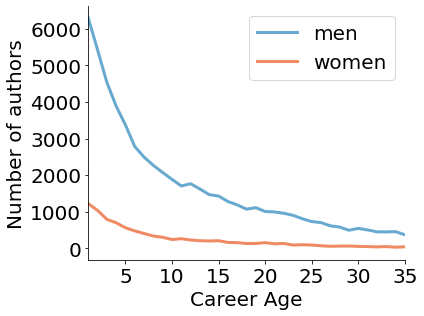

In [5]:
# Career age vs. Number of authors, separated by gender
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Men authors
ca_m.plot(color='#67a9cf', lw=3)
# Women authors
ca_w.plot(color='#ef8a62', lw=3)

plt.xticks(fontsize=20)
plt.xlim(1,35)
plt.yticks(fontsize=20)
plt.legend(['men', 'women'], loc='upper right', fontsize=20)
plt.xlabel('Career Age', fontsize=20)
plt.ylabel('Number of authors', fontsize=20)
plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/SI_Fig_4.pdf")

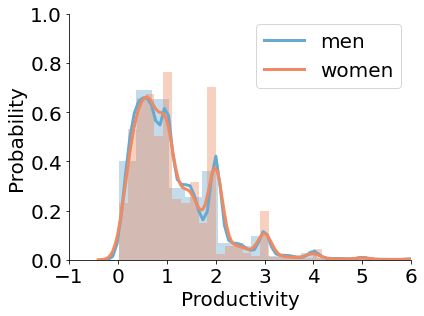

In [79]:
# Comparing PDFs

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

ax1 = sns.distplot(prod_m['prod'], ax=ax, label='male', color= '#67a9cf',kde_kws=dict(linewidth=3))
fit = ax1.get_lines()[0].get_data() # Getting the data from the plotted line
xfit, yfit = fit[0], fit[1]
ax1.legend()

ax2 = sns.distplot(prod_w['prod'], ax=ax, label='female', color= '#ef8a62',kde_kws=dict(linewidth=3))
fit = ax2.get_lines()[0].get_data() # Getting the data from the plotted line
xfit, yfit = fit[0], fit[1]
ax2.legend()

plt.legend(('men', 'women'), loc='upper right', fontsize=20)
plt.xlabel('Productivity', fontsize=20)
plt.xlim(xmin=-1, xmax=6)
plt.ylim(ymax=1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Probability', fontsize=20)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/SI_Fig_5A.pdf")

In [33]:
# creating CDF data for productivity

from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import interp1d

cdf1=np.arange(len(prod_m))/float(len(prod_m)-1)
cdf2=np.arange(len(prod_w))/float(len(prod_w)-1)

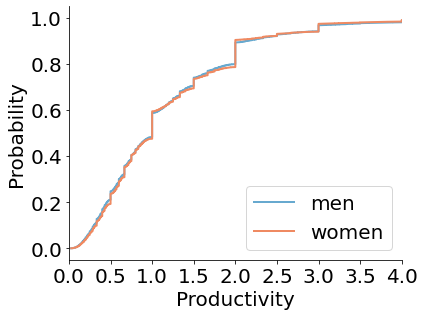

In [36]:
# Productivity CDF Plots
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Men authors
plt.plot(prod_m['prod'],1-cdf1, color='#67a9cf', lw=2)
# Women authors
plt.plot(prod_w['prod'],1-cdf2, color='#ef8a62', lw=2)

plt.xlabel('Productivity', fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(xmin=0, xmax=4)
plt.ylabel('Probability', fontsize=20)
plt.yticks(fontsize=20)
plt.legend(['men', 'women'], loc='lower right', fontsize=20)
plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/SI_Fig_5B.pdf")

In [68]:
# Run K-S test to compare the productivity

print(ks_2samp(prod_m['prod'], prod_w['prod']))
print(ks_2samp(prod_m['prod'], prod_w['prod'], alternative='greater'))
print(ks_2samp(prod_m['prod'], prod_w['prod'], alternative='less'))

KstestResult(statistic=0.01804639561273677, pvalue=0.01010865442868039)
KstestResult(statistic=0.01804639561273677, pvalue=0.005047485308957038)
KstestResult(statistic=0.011262321824869526, pvalue=0.12706574771266033)


We see greater difference in productivity in favor of men authors.

In [69]:
# find out where the greatest difference in productivity occurs

def ks_2samp_x(data1, data2, alternative="two-sided"):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]

    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    cddiffs = cdf1 - cdf2
    minS = np.argmin(cddiffs)   # ks_2samp uses np.min or np.max respectively 
    maxS = np.argmax(cddiffs)   # now we get instead the index in data_all
    alt2Dvalue = {'less': minS, 'greater': maxS, 'two-sided': max(minS, maxS)}
    d_arg = alt2Dvalue[alternative]
    return data_all[d_arg]

print(ks_2samp_x(prod_m['prod'], prod_w['prod'], alternative='greater'))

0.4909090909090909


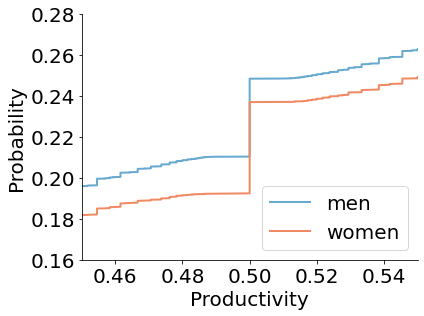

In [75]:
# Productivity CDF Plots
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Men authors
plt.plot(prod_m['prod'],1-cdf1, color='#67a9cf', lw=2)
# Women authors
plt.plot(prod_w['prod'],1-cdf2, color='#ef8a62', lw=2)

plt.xlabel('Productivity', fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(xmin=0, xmax=4)
plt.ylabel('Probability', fontsize=20)
plt.yticks(fontsize=20)
plt.legend(['men', 'women'], loc='lower right', fontsize=20)
plt.tight_layout()

# Use the following xlim, ylim instead for zoomed-in plot
plt.xlim(xmin=0.45, xmax=0.55)
plt.ylim(ymin=0.16, ymax=0.28)
plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/SI_Fig_5C.pdf")

### Dropout Rate Comparison

In [6]:
# exclude authors who enter APS publication after 2004
# create scatterplot of dropout authors by career age

dropout = prod[prod['year']['min'] < 2004].groupby(
    ['gender', 'career_age'])['career_age'].count()

dropout_m = dropout['male'].sort_index(ascending=False)
dropout_w = dropout['female'].sort_index(ascending=False)

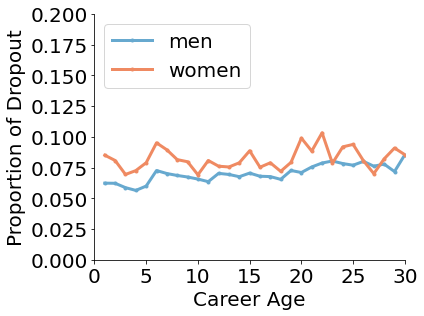

In [7]:
# Career Age vs. Proportion of Dropout (plot)

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Men authors
(dropout_m/dropout_m.cumsum()).iloc[::-1].plot(
    style='.-', color='#67a9cf', lw=3)
# Women authors
(dropout_w/dropout_w.cumsum()).iloc[::-1].plot(
    style='.-',color='#ef8a62', lw=3)

plt.legend(('men', 'women'), loc='upper left', fontsize=20)
plt.xlabel('Career Age', fontsize=20)
plt.xlim(0,30)
plt.ylabel('Proportion of Dropout', fontsize=20)
plt.ylim(0, 0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/Fig_1C.pdf")

### Career Age Analysis

In [8]:
# Set up DataFrames for Career Age vs. Average number of publications
# separated by gender

subdata = paperdata.copy().drop(['order','doi','numAuthor',
                                 'is_alpha','articleType','journal'],
                    axis=1).sort_values(by=['id', 'year'])
subdata["ca"] = subdata.groupby("id")["year"].transform(lambda x: x - x.min())

subdata_m = subdata[subdata['gender'] == 'male'].drop(
    ['gender', 'year'], axis=1).groupby(['id', 'ca']).size().to_frame(
    name='count').reset_index(level='id', drop=True).reset_index()

subdata_w = subdata[subdata['gender'] == 'female'].drop(
    ['gender', 'year'], axis=1).groupby(['id', 'ca']).size().to_frame(
    name='count').reset_index(level='id', drop=True).reset_index()

subdata_m = subdata_m.groupby("ca").agg(
    ['count', np.mean, np.std]).reset_index()
subdata_w = subdata_w.groupby("ca").agg(
    ['count', np.mean, np.std]).reset_index()

In [9]:
# Calculate standard error for the shaded area in plots

semlist1, semlist2 = [], []

for i in range(len(subdata_m)):
    semlist1.append(subdata_m["count"]['std'][i]/math.sqrt(subdata_m["count"]['count'][i]))
subdata_m['sem'] = semlist1

for i in range(len(subdata_w)):
    semlist2.append(subdata_w["count"]['std'][i]/math.sqrt(subdata_w["count"]['count'][i]))
subdata_w['sem'] = semlist2

# Append to the existing DataFrames
subdata_m = subdata_m.set_index('ca').reindex(range(
    subdata_m.ca.min(),subdata_m.ca.max()+1)).fillna(np.nan).reset_index()
subdata_w = subdata_w.set_index('ca').reindex(range(
    subdata_w.ca.min(),subdata_w.ca.max()+1)).fillna(np.nan).reset_index()

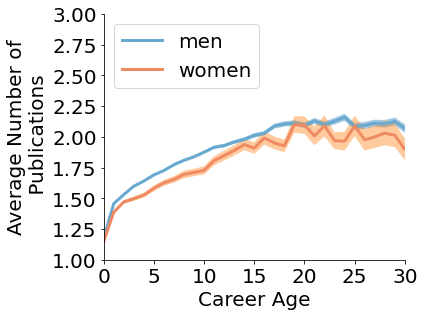

In [10]:
# Career age vs. Average number of publications (plot)

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Men authors
plt.plot(subdata_m.ca,subdata_m["count"]["mean"],"-",label="men",
         color='#67a9cf', lw=3)

# shading the SE area (man)
X  = np.linspace(min(subdata_m.ca),max(subdata_m.ca),subdata_m.ca.nunique())
plt.fill_between(X,
                 subdata_m["count"]["mean"] + subdata_m["sem"],
                 subdata_m["count"]["mean"] - subdata_m["sem"],
                 color='C0',alpha=.4,edgecolor="none")

# Women authors
plt.plot(subdata_w.ca,subdata_w["count"]["mean"],"-",label="women",
         color='#ef8a62', lw=3)

# shading the SE area (woman)
X  = np.linspace(min(subdata_w.ca),max(subdata_w.ca),subdata_w.ca.nunique())
plt.fill_between(X,
                 subdata_w["count"]["mean"] + subdata_w["sem"],
                 subdata_w["count"]["mean"] - subdata_w["sem"],
                 color='C1',alpha=.4,edgecolor="none")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Career Age",fontsize=20)
plt.ylabel("Average Number of\n Publications",fontsize=20)
plt.xlim(xmin=0, xmax=30)
plt.ylim(ymin=1, ymax=3)
plt.legend(loc='upper left', fontsize=20)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/Fig_1B.pdf")

# Network / Similarity Analyses

## Pair matching (Pre-requisite)

In [32]:
# DataFrame: {citing_doi, citing_year, cited_doi}

citinfo = primdata[["doi", "year"]].drop_duplicates(subset = 'doi')
cols = ['citing_doi', 'citing_year', 'cited_doi']

citinfo = citinfo.merge(cb, left_on = 'doi', right_on = 'citing_doi',
              how = 'inner').drop(['doi'], axis=1).rename(
                  {'year': 'citing_year'}, axis=1).reindex(
                      columns=cols).sort_values('cited_doi')

citinfo.head()

,citing_doi,citing_year,cited_doi
120140,10.1103/PhysRev.2.109,1913,10.1103/PhysRev.1.124
123113,10.1103/PhysRev.40.281,1932,10.1103/PhysRev.1.124
120191,10.1103/PhysRev.21.250,1923,10.1103/PhysRev.1.124
144119,10.1103/PhysRev.8.738,1916,10.1103/PhysRev.1.124
2740023,10.1103/PhysRevSeriesI.2.1,1894,10.1103/PhysRev.1.2


### Preparing m-w similar pairs

In [18]:
# dealing with massive pair dataFrame

pair = list(pair)
mfpairs = pd.DataFrame(columns=list(pair[0].columns))

KeyboardInterrupt: 

In [33]:
# choosing pairs where one primary author is woman and the other is man

for p in tqdm(pair):
    mfpairs = pd.concat([mfpairs, p[p['gender1'] != p['gender2']]])

100%|██████████| 69/69 [31:34<00:00, 27.46s/it]


In [58]:
mfpairs = mfpairs.drop_duplicates().reset_index(drop=True)
print(len(mfpairs))

mfpairs.to_csv(f'/Users/robinkong/codes/mfpairs.csv',index=False)

14490273


In [59]:
len(mfpairs[mfpairs['qval']<0.002])/len(mfpairs)

0.10173576439864176

### Preparing m-m similar pairs

In [19]:
# dealing with massive pair dataFrame

pair = list(pair)
mmpairs = pd.DataFrame(columns=list(pair[0].columns))

In [ ]:
# choosing pairs where both primary authors are men

for p in tqdm(pair):
    mmpairs = pd.concat([mmpairs, p[(p.gender1 == 'male') & (p.gender2 == 'male')]])

 54%|█████▎    | 37/69 [37:59<1:12:04, 135.13s/it]

In [ ]:
mmpairs = mmpairs.drop_duplicates().reset_index(drop=True)
print(len(mmpairs))

mmpairs.to_csv(f'/Users/robinkong/codes/mmpairs.csv',index=False)

### Preparing w-w similar pairs

In [5]:
# dealing with massive pair dataFrame

pair = list(pair)
wwpairs = pd.DataFrame(columns=list(pair[0].columns))

In [7]:
# choosing pairs where both primary authors are men

for p in tqdm(pair):
    wwpairs = pd.concat([wwpairs, p[(p.gender1 == 'female') & (p.gender2 == 'female')]])

100%|██████████| 65/65 [01:20<00:00,  1.24s/it]


In [8]:
wwpairs = wwpairs.drop_duplicates().reset_index(drop=True)
print(len(wwpairs))

wwpairs.to_csv(f'/Users/robinkong/codes/wwpairs.csv',index=False)

1039037


### Counting for each similar pair (m-w pairs)

In [5]:
sim_mf = mfpairs[['paper1', 'paper2', 'gender1', 'gender2', 'year1', 'year2', 'keyval', 'qval']]

In [ ]:
# Create a dummy data (test1, test2) to perform SQL:
# Create a DataFrame that treats citation info for male and female papers
test1 = sim_mf.merge(citinfo, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test1['count'] = test1.groupby(['paper1'])['paper1'].transform('count')
test1 = test1.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test1 = test1.drop_duplicates(subset=['paper1', 'paper2'])[['paper1', 'count1']]
sim_mf = sim_mf.merge(test1, on='paper1', how='inner')

test2 = sim_mf.merge(citinfo, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test2['count'] = test2.groupby(['paper2'])['paper2'].transform('count')
test2 = test2.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2'])[['paper2', 'count2']]
sim_mf = sim_mf.merge(test2, on='paper2', how='inner')

# Delete the dummy data
del test1
del test2

In [22]:
# Calculate year & centrality difference among pairs

listd = []
listy = []

for c in range(len(sim_mf)):
    if sim_mf['gender1'][c] == 'male':
        listd.append(sim_mf['count1'][c] - sim_mf['count2'][c])
        listy.append(sim_mf['year1'][c] - sim_mf['year2'][c])
    else:
        listd.append(sim_mf['count2'][c] - sim_mf['count1'][c])
        listy.append(sim_mf['year2'][c] - sim_mf['year1'][c])

sim_mf['countd'] = listd
sim_mf['yeard'] = listy

# Keep the minimum q-value per pair
sim_mf = sim_mf.sort_values('qval').drop_duplicates(
    subset=['paper1', 'paper2'], keep='first')

100%|██████████| 14490273/14490273 [10:25<00:00, 23159.47it/s]


In [38]:
sim_mf.to_csv("/Users/robinkong/codes/mfpairs_similarity.csv", index=False)

### Counting for each similar pair (w-w pairs)

In [10]:
sim_ww = wwpairs[['paper1', 'paper2', 'gender1', 'gender2', 'year1', 'year2', 'keyval', 'qval']]

In [11]:
# Create a dummy data (test1, test2) to perform SQL:
# Create a DataFrame that treats citation info for male and female papers
test1 = sim_ww.merge(citinfo, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test1['count'] = test1.groupby(['paper1'])['paper1'].transform('count')
test1 = test1.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test1 = test1.drop_duplicates(subset=['paper1', 'paper2'])[['paper1', 'count1']]
sim_ww = sim_ww.merge(test1, on='paper1', how='inner')

test2 = sim_ww.merge(citinfo, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test2['count'] = test2.groupby(['paper2'])['paper2'].transform('count')
test2 = test2.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2'])[['paper2', 'count2']]
sim_ww = sim_ww.merge(test2, on='paper2', how='inner')

# Delete the dummy data
del test1
del test2

In [13]:
# Calculate year & centrality difference among pairs

listd = []
listy = []

for c in tqdm(range(len(sim_ww))):
    if sim_ww['gender1'][c] == 'male':
        listd.append(sim_ww['count1'][c] - sim_ww['count2'][c])
        listy.append(sim_ww['year1'][c] - sim_ww['year2'][c])
    else:
        listd.append(sim_ww['count2'][c] - sim_ww['count1'][c])
        listy.append(sim_ww['year2'][c] - sim_ww['year1'][c])

sim_ww['countd'] = listd
sim_ww['yeard'] = listy

# Keep the minimum q-value per pair
sim_ww = sim_ww.sort_values('qval').drop_duplicates(
    subset=['paper1', 'paper2'], keep='first')

100%|██████████| 1039037/1039037 [00:40<00:00, 25500.71it/s]


In [15]:
sim_ww.to_csv("/Users/robinkong/codes/wwpairs_similarity.csv", index=False)

## Self-citation Analysis

In [51]:
self1 = citinfo.copy()
self2 = primdata[['doi','id','gender']]

selfinfo = self1.merge(self2, left_on='citing_doi', right_on='doi').drop(
    ['citing_doi', 'doi'], axis=1).drop_duplicates().reset_index(drop=True)
selfinfo.columns = ['citing_year', 'cited_doi', 'citing_id', 'citing_gender']

selfinfo = selfinfo.merge(self2, left_on='cited_doi', right_on='doi').drop(
    ['cited_doi', 'doi', 'gender'], axis=1).drop_duplicates().reset_index(drop=True)
selfinfo.columns = ['citing_year', 'citing_id', 'citing_gender', 'cited_id']

selfinfo.head()

,citing_year,citing_id,citing_gender,cited_id
0,1913,109426,male,106864
1,1932,211997,male,106864
2,1923,212878,male,106864
3,1916,165511,female,106864
4,1913,109426,male,31368


In [46]:
# create a DataFrame with self-citing authors by gender

# all sample (population)
pop = selfinfo.copy().groupby(['citing_year'])['citing_year'].count()

# men authors
mpop = selfinfo.copy().loc[selfinfo['citing_gender'] == 'male'].groupby(
    ['citing_year'])['citing_year'].count()
# women authors
wpop = selfinfo.copy().loc[selfinfo['citing_gender'] == 'female'].groupby(
    ['citing_year'])['citing_year'].count()

# self citing authors
selfcit = selfinfo.copy().loc[selfinfo['citing_id'] == selfinfo['cited_id']].groupby(
    ['citing_year'])['citing_year'].count()

# men self citing authors
m_sc = selfinfo.copy().loc[(selfinfo['citing_id'] == selfinfo['cited_id']) &
                   (selfinfo['citing_gender'] == 'male')].groupby(
                       ['citing_year'])['citing_year'].count()
# women self citing authors
w_sc = selfinfo.copy().loc[(selfinfo['citing_id'] == selfinfo['cited_id']) & 
                     (selfinfo['citing_gender'] == 'female')].groupby(
                         ['citing_year'])['citing_year'].count()

# missing values to 0
pop[np.isnan(pop)] = 0
mpop[np.isnan(mpop)] = 0
wpop[np.isnan(wpop)] = 0
selfcit[np.isnan(selfcit)] = 0
m_sc[np.isnan(m_sc)] = 0
w_sc[np.isnan(w_sc)] = 0

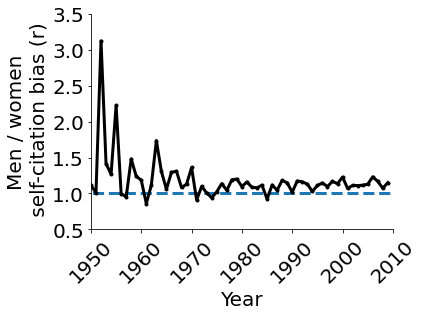

In [50]:
# calculate r-value
r1 = ((m_sc/selfcit)/(w_sc/selfcit))
r2 = ((wpop/pop)/(mpop/pop))
r = r1*r2

# create r-value plot
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

r.plot(style='.-', color='black', lw=3)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1950)
# plt.xlim(xmin=1960)
plt.xlim(xmax=2010)
plt.ylabel('Men / women\n self-citation bias (r)', fontsize=20)
plt.ylim(ymin=0.5,ymax=3.5)
# plt.ylim(ymin=0.5,ymax=2.5)
plt.hlines(1,xmin=1903,xmax=2010,linestyles='dashed', lw=3)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/Fig_1D.pdf")

## Degree & PageRank Centrality Statistics

### Degree Centrality Proportion of Women Authors

In [12]:
# exclude alphabetically ordered papers
# only consider primary authors
degcen = paperdata.query('is_alpha == False & order == 1')

# calculate degree centrality per paper
vc = cb['cited_doi'].value_counts()
cb_sub = vc[vc.to_numpy() > 0].to_frame()

# create a DataFrame with degree centrality
cited = pd.merge(cb_sub, degcen, left_index = True, right_on = 'doi')
cited['yeard'] = 2010-cited['year']
cited.head()

,cited_doi,doi,id,gender,order,numAuthor,is_alpha,year,articleType,journal,...,pacs10,pacs20,pacs30,pacs40,pacs50,pacs60,pacs70,pacs80,pacs90,yeard
16644,5214,10.1103/PhysRev.140.A1133,219005,male,1,2,False,1965,article,PR,...,0,0,0,0,0,0,0,0,0,45
14878,4100,10.1103/PhysRev.136.B864,12626,male,1,2,False,1964,article,PR,...,0,0,0,0,0,0,0,0,0,46
151046,2519,10.1103/PhysRevB.13.5188,133666,male,1,2,False,1976,article,PRB,...,0,0,0,0,0,0,0,0,0,34
258031,2337,10.1103/PhysRevB.54.11169,157378,male,1,2,False,1996,article,PRB,...,0,0,0,0,0,0,1,0,0,14
3428,1679,10.1103/PhysRev.108.1175,165388,male,1,3,False,1957,article,PR,...,0,0,0,0,0,0,0,0,0,53


In [13]:
def cummean(x):
    return x.cumsum() / (np.arange(1, len(x) + 1))

# def plot_topk_mean_m(x):
#     n = len(x)
#     plt.plot(100 * (1 + np.arange(n)) / n, cummean(x[::-1]), color='#67a9cf',
#              lw=3, label='men')

# def plot_topk_mean_w(x):
#     n = len(x)
#     plt.plot(100 * (1 + np.arange(n)) / n, cummean(x[::-1]), color='#ef8a62',
#              lw=3, label='women')

def plot_topk_mean_w(x):
    n = len(x)
    plt.plot(100 * (1 + np.arange(n)) / n, cummean(x[::-1]), color='black',
             lw=3)

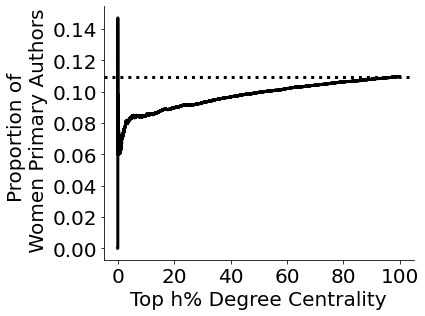

In [14]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plot_topk_mean_w(cited.sort_values(by='cited_doi')['gender'] == 'female')

plt.axhline(y=len(cited[cited['gender'] == 'female'])/len(cited),
            color='black', linestyle='dotted', lw=3)

plt.xlabel("Top h% Degree Centrality", fontsize=20)
plt.ylabel("Proportion of \n Women Primary Authors", fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

# plt.legend(loc='upper right', fontsize=20)
fig.savefig(f"/Users/robinkong/codes/Fig_3A_degree.pdf")

### PageRank Centrality Proportion of Women Authors

In [15]:
cen1 = cb.copy()
cen2 = primdata[['doi','gender']]

cen = cen1.merge(cen2, left_on='citing_doi', right_on='doi').drop('doi', axis=1).reset_index(drop=True)
cen = cen.merge(cen2, left_on='cited_doi', right_on='doi').drop('doi', axis=1).reset_index(drop=True)
cen.columns = ['citing_doi', 'cited_doi', 'citing_gender', 'cited_gender']
cen.head()

,citing_doi,cited_doi,citing_gender,cited_gender
0,10.1103/PhysRevSeriesI.11.215,10.1103/PhysRevSeriesI.1.1,male,male
1,10.1103/PhysRevSeriesI.17.267,10.1103/PhysRevSeriesI.1.1,male,male
2,10.1103/RevModPhys.51.863,10.1103/PhysRevSeriesI.1.1,male,male
3,10.1103/PhysRevSeriesI.4.433,10.1103/PhysRevSeriesI.1.1,male,male
4,10.1103/PhysRevSeriesI.17.267,10.1103/PhysRevSeriesI.11.215,male,male


In [16]:
# apply nx.graph to citation relationship network
Graphtype = nx.DiGraph()

C = nx.from_pandas_edgelist(cen, source='citing_doi',
                            target='cited_doi', create_using=Graphtype)
print(nx.info(C))

Name: 
Type: DiGraph
Number of nodes: 267446
Number of edges: 1899640
Average in degree:   7.1029
Average out degree:   7.1029


In [17]:
# observe author id & gender (primary author)
nodedata = primdata[['doi','id','gender']]

In [18]:
# assign PageRank centrality to each paper
pr = nx.pagerank(C)

# create a centrality dataframe
prs = pd.DataFrame()
prs['doi'] = pr.keys()
prs['PRcen'] = pr.values()

# merge and create a dataframe: id, gender, PageRank centrality
prs_new = prs.merge(nodedata, on='doi', how='left').sort_values('PRcen', ascending=False)
prs_new.head()

,doi,PRcen,id,gender
5469,10.1103/PhysRev.140.A1133,0.001709,219005,male
42329,10.1103/PhysRev.136.B864,0.001404,12626,male
33589,10.1103/PhysRev.108.1175,0.001370,165388,male
48,10.1103/PhysRev.47.777,0.001022,38494,male
117022,10.1103/PhysRev.65.117,0.000763,59830,male


In [19]:
pr_age = prs_new.merge(cited, on='doi', how='inner')
pr_age = pr_age[['PRcen', 'doi', 'id_x', 'gender_x', 'yeard']]
pr_age = pr_age.rename(columns={'id_x': "id", "gender_x": "gender"}
                      ).sort_values('PRcen',ascending=False)

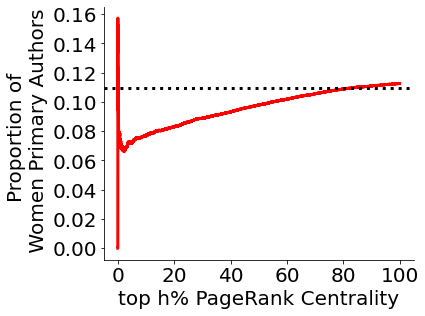

In [20]:
# Comparative graph for actual female proportion vs. expected female proportion

prs_gender = prs_new['gender'].to_numpy()
cumulate_prs_gender = np.cumsum(prs_gender == "female")

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot((np.arange(len(prs_new))*100)/len(prs_new),
         cumulate_prs_gender/np.arange(1, len(prs_new)+1), color='red', lw=3)
# plt.axhline(y=0.08274119036274367, color='black', linestyle='dotted', lw=3)
plt.axhline(y=len(cited[cited['gender'] == 'female'])/len(cited),
            color='black', linestyle='dotted', lw=3)

plt.xlabel("top h% PageRank Centrality", fontsize=20)
plt.ylabel("Proportion of \n Women Primary Authors", fontsize = 20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/Fig_3A_PageRank.pdf")

## Similarity Validation Statistics

In [76]:
# filter conditions

# sdoi = primdata[primdata['journal'] == "PRL"].doi
# sdoi = primdata[primdata['pacs90'] == 1].doi

df = sim_mf.copy()

# df = df[df['paper1'].isin(sdoi)]
# df = df[df['paper2'].isin(sdoi)].reset_index(drop=True)

In [ ]:
# filter year constraints

N = 3

df = df[df['yeard'] >= -N]
df = df[df['yeard'] <= N].reset_index(drop=True)

In [77]:
p = 0.001
df_vld = df[df['qval'] < p]

print("N: ", len(df))
print("M: ", len(df_vld))
print("M/N: ", len(df_vld)/len(df))

N:  2730100
M:  410418
M/N:  0.15033075711512398


In [78]:
# getting mlist and fmlist (count per gender)

mlist = []
fmlist = []

for i in tqdm(range(len(df_vld))):
    if df_vld['gender1'][i] == 'male':
        mlist.append(df_vld['count1'][i])
        fmlist.append(df_vld['count2'][i])
    else:
        mlist.append(df_vld['count2'][i])
        fmlist.append(df_vld['count1'][i])

# Find z-scores (for p-values)
ztest(mlist, fmlist, value=0)

100%|██████████| 410418/410418 [00:04<00:00, 95449.02it/s]


(19.150151095942956, 9.65063481804804e-82)

In [ ]:
# Find z-scores (for p-values)
print(ztest(mlist, fmlist, value=0))
print('')

# Find effect size
print(pg.compute_effsize(mlist, fmlist, paired=True, eftype='hedges'))

## Centrality Difference Trend by Year (m-f pairs)

In [2]:
sim_mf = pd.read_csv("/Users/robinkong/codes/mfpairs_similarity.csv")
sim_mf.head()

,paper1,paper2,gender1,gender2,year1,year2,keyval,qval,count1,count2,countd,yeard
0,10.1103/PhysRevB.74.035411,10.1103/PhysRevB.75.205440,female,male,2006,2007,4,-1.117244e-10,1,1,0,1
1,10.1103/PhysRevB.73.075112,10.1103/PhysRevB.74.045113,female,male,2006,2006,4,-1.117173e-10,9,2,-7,0
2,10.1103/PhysRev.88.1109,10.1103/RevModPhys.24.321,male,female,1952,1952,2,-9.355250e-11,45,79,-34,0
3,10.1103/PhysRevE.70.011103,10.1103/PhysRevE.70.056128,male,female,2004,2004,3,-8.545054e-11,1,1,0,0
4,10.1103/PhysRevB.76.174508,10.1103/PhysRevLett.99.087001,male,female,2007,2007,3,-8.545054e-11,1,3,-2,0


In [3]:
mfs = sim_mf[sim_mf['yeard'] <= 3]
mfs = mfs[mfs['yeard'] >= -3].reset_index(drop=True)

lateryear = []

for i in tqdm(range(len(mfs))):
    lateryear.append(max(mfs['year1'][i], mfs['year2'][i]))

mfs['lateryear'] = lateryear

mfs.head()

100%|██████████| 5611686/5611686 [00:36<00:00, 153994.48it/s]


,paper1,paper2,gender1,gender2,year1,year2,keyval,qval,count1,count2,countd,yeard,lateryear
0,10.1103/PhysRevB.74.035411,10.1103/PhysRevB.75.205440,female,male,2006,2007,4,-1.117244e-10,1,1,0,1,2007
1,10.1103/PhysRevB.73.075112,10.1103/PhysRevB.74.045113,female,male,2006,2006,4,-1.117173e-10,9,2,-7,0,2006
2,10.1103/PhysRev.88.1109,10.1103/RevModPhys.24.321,male,female,1952,1952,2,-9.355250e-11,45,79,-34,0,1952
3,10.1103/PhysRevE.70.011103,10.1103/PhysRevE.70.056128,male,female,2004,2004,3,-8.545054e-11,1,1,0,0,2004
4,10.1103/PhysRevB.76.174508,10.1103/PhysRevLett.99.087001,male,female,2007,2007,3,-8.545054e-11,1,3,-2,0,2007


In [91]:
p = 0.001

simp = mfs[mfs['qval'] < p].sort_values('countd').reset_index(drop=True)
print(len(simp)/len(mfs))

simp_mw = simp[['lateryear', 'countd']].sort_values(by=['lateryear', 'countd'])

0.10213864425058708


In [6]:
simp_mw_yr = simp_mw.groupby(['lateryear'])['lateryear'].count()
simp_mw_yr.head()

lateryear
1903    3
1916    1
1918    1
1921    1
1923    2
Name: lateryear, dtype: int64

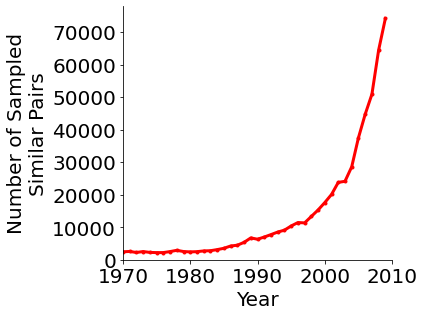

In [7]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

simp_mw_yr.plot(style='.-',color='red', lw=3)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1970, xmax=2010)
plt.xticks(np.arange(1970, 2011, 10), fontsize=20)
plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/SI_Fig_7.pdf")

In [12]:
simp_mw_yr = pd.DataFrame({'year':simp_mw_yr.index, 'count':simp_mw_yr.values})

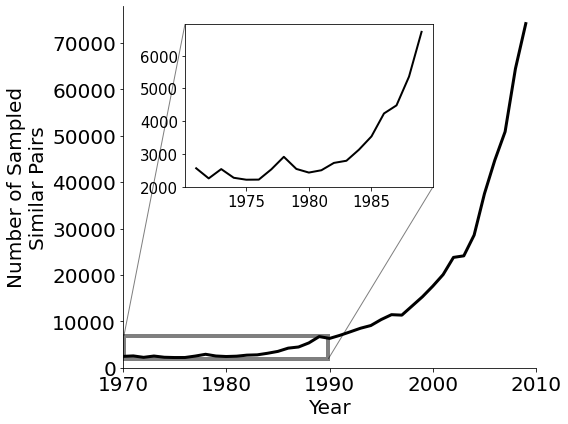

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot(simp_mw_yr['year'], simp_mw_yr['count'], color='black', lw=3)

inset_ax = ax.inset_axes([0.15, 0.5, 0.6, 0.45])
inset_ax.plot(simp_mw_yr['year'][52:71], simp_mw_yr['count'][52:71], color='black', lw=2)
inset_ax.tick_params(labelsize=15)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1970, xmax=2010)
plt.xticks(np.arange(1970, 2011, 10), fontsize=20)
plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)
ax.indicate_inset_zoom(inset_ax, edgecolor="black", linewidth = 4)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/simpairs_zoomed.pdf")

## Comparing similar m-m pairs and m-w pairs

### Percentile plots of centrality difference by year

In [22]:
# man-man pairs

sim_mm = pd.read_csv("/Users/robinkong/codes/mmpairs_similarity.csv")

# apply year restriction

mms = sim_mm[sim_mm['yeard'] <= 3]
mms = mms[mms['yeard'] >= -3].reset_index(drop=True)

# label the publication year of pairs as the publication year of a latter one

lateryear = []

for i in tqdm(range(len(mms))):
    lateryear.append(max(mms['year1'][i], mms['year2'][i]))

mms['lateryear'] = lateryear

# apply similarity threshold

p = 0.001

simp_mm = mms[mms['qval'] < p].sort_values('countd').reset_index(drop=True)
print(len(simp_mm)/len(mms))

simp_mm = simp_mm[['lateryear', 'countd']].sort_values(by=['lateryear', 'countd'])

100%|██████████| 19193545/19193545 [02:12<00:00, 144931.66it/s]


0.11612544738348231


In [23]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [24]:
# find the percentile statistics for m-w pairs

paired_mf = simp_mw.groupby('lateryear').agg([np.mean, percentile(10), percentile(20),
                                      percentile(30), percentile(40), np.median,
                                      percentile(60), percentile(70), percentile(80),
                                      percentile(90)]).reset_index()

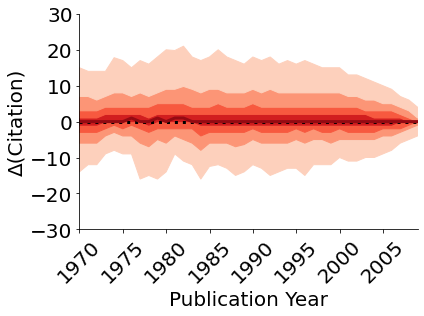

In [87]:
# m-w pair percentile plot

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

cm = sns.color_palette("Reds",10)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
plt.plot(paired_mf.lateryear,paired_mf.countd["median"],"-",label="M-F Median", color=cm[9], lw=3)

plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_10"],
                 paired_mf.countd["percentile_20"], color=cm[1])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_20"],
                 paired_mf.countd["percentile_30"], color=cm[3])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_30"],
                 paired_mf.countd["percentile_40"], color=cm[5])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_40"],
                 paired_mf.countd["median"], color=cm[7])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["median"],
                 paired_mf.countd["percentile_60"], color=cm[7])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_60"],
                 paired_mf.countd["percentile_70"], color=cm[5])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_70"],
                 paired_mf.countd["percentile_80"], color=cm[3])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_80"],
                 paired_mf.countd["percentile_90"], color=cm[1])

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.xlabel("Publication Year", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)

plt.xlim(xmin=1970, xmax=2009)
plt.ylim(ymin=-30, ymax=30)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/mfpair_pp.pdf")

In [27]:
ref = simp_mw.lateryear.unique()
numlist = []

mm_centrality = pd.DataFrame(columns=['lateryear'])

for num in ref:
    numlist.append(num)
mm_centrality['lateryear'] = numlist

# take the average of 100 random m-m pair samples per year and calculate the centrality difference

for k in tqdm(range(100)):
    df1 = pd.DataFrame(columns=['lateryear', 'countd'])
    vlist = []

    for i in range(len(ref)):
        df2 = simp_mm[simp_mm['lateryear'] == ref[i]].sample(
            simp_mwsimp.lateryear.value_counts().sort_index().iloc[i], replace=True)
        df1 = pd.concat([df1,df2])
    
    for j in range(len(df1)):
        if randint(0,1) == 0:
            vlist.append(df1.countd.iloc[j])
        else:
            vlist.append(df1.countd.iloc[j] * -1)
    
    df1['value'] = vlist
    df1 = df1.groupby("lateryear").agg([np.mean]).reset_index().drop(['lateryear'], axis=1)

    mm_centrality = pd.concat([mm_centrality, df1], axis=1)

mm_centrality.head()

,lateryear,"(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)",...,"(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)"
0,1903,0.0,0.666667,0.666667,0.0,-0.666667,-0.666667,0.0,0.0,0.0,...,0.0,-0.666667,0.0,0.0,0.666667,-1.333333,-0.666667,0.0,-0.666667,0.0
1,1916,-6.0,1.000000,1.000000,0.0,5.000000,-5.000000,-1.0,-9.0,0.0,...,0.0,0.000000,1.0,-9.0,0.000000,6.000000,-6.000000,-1.0,-6.000000,-9.0
2,1918,0.0,-2.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,1.0,...,-14.0,1.000000,0.0,-14.0,-2.000000,-2.000000,-1.000000,-1.0,-1.000000,-2.0
3,1921,-1.0,3.000000,3.000000,-1.0,-3.000000,-2.000000,-1.0,-2.0,-3.0,...,0.0,1.000000,0.0,2.0,1.000000,2.000000,-2.000000,0.0,1.000000,1.0
4,1923,-0.5,1.000000,-1.500000,1.5,4.500000,-6.500000,0.0,6.5,-0.5,...,0.5,5.000000,-5.5,1.5,0.500000,-4.500000,-5.500000,1.0,-0.500000,5.0


In [78]:
# record the percentiles of the average statistics of 100 m-m pairs per year

paired_mm = mm_centrality.copy()

list_1, list_2, list_3, list_4, list_5, list_6, list_7, list_8, list_9 = [], [], [], [], [], [], [], [], []

for i in range(len(paired_mm)):
    list_1.append(np.percentile(paired_mm.iloc[i,1:],10))
    list_2.append(np.percentile(paired_mm.iloc[i,1:],20))
    list_3.append(np.percentile(paired_mm.iloc[i,1:],30))
    list_4.append(np.percentile(paired_mm.iloc[i,1:],40))
    list_5.append(np.median(paired_mm.iloc[i,1:]))
    list_6.append(np.percentile(paired_mm.iloc[i,1:],60))
    list_7.append(np.percentile(paired_mm.iloc[i,1:],70))
    list_8.append(np.percentile(paired_mm.iloc[i,1:],80))
    list_9.append(np.percentile(paired_mm.iloc[i,1:],90))

paired_mm['percentile_10'] = list_1
paired_mm['percentile_20'] = list_2
paired_mm['percentile_30'] = list_3
paired_mm['percentile_40'] = list_4
paired_mm['median'] = list_5
paired_mm['percentile_60'] = list_6
paired_mm['percentile_70'] = list_7
paired_mm['percentile_80'] = list_8
paired_mm['percentile_90'] = list_9

paired_mm = paired_mm[['lateryear', 'percentile_10','percentile_20','percentile_30',
                       'percentile_40','median','percentile_60','percentile_70',
                       'percentile_80','percentile_90']]

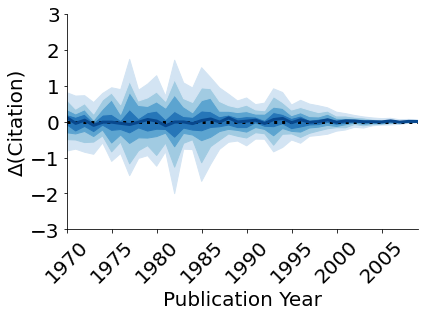

In [89]:
# m-m averaged percentile plot

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

cm2 = sns.color_palette("Blues",10)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
plt.plot(paired_mm.lateryear,paired_mm["median"],"-",label="M-M Median", color=cm2[9], lw=3)

plt.fill_between(paired_mm.lateryear, paired_mm["percentile_10"],
                 paired_mm["percentile_20"], color=cm2[1])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_20"],
                 paired_mm["percentile_30"], color=cm2[3])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_30"],
                 paired_mm["percentile_40"], color=cm2[5])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_40"],
                 paired_mm["median"], color=cm2[7])
plt.fill_between(paired_mm.lateryear, paired_mm["median"],
                 paired_mm["percentile_60"], color=cm2[7])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_60"],
                 paired_mm["percentile_70"], color=cm2[5])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_70"],
                 paired_mm["percentile_80"], color=cm2[3])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_80"],
                 paired_mm["percentile_90"], color=cm2[1])

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.xlabel("Publication Year", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)

plt.xlim(xmin=1970, xmax=2009)
plt.ylim(ymin=-3, ymax=3)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/mmpair_pp.pdf")

### Centrality differences of similar m-m & m-f pairs by year

In [28]:
# mm_ms is the DataFrame for the difference plot (M-M pairs)
mm_ms = mm_centrality.copy()

# Retrieving the list of means and SDs
meanlist = mm_ms.iloc[:,1:].mean(axis=1).tolist()
sdlist = mm_ms.iloc[:,1:].std(axis=1).tolist()

# Appending to the DataFrame
mm_ms['avg'] = meanlist
mm_ms['sd'] = sdlist
mm_ms = mm_ms[['lateryear','avg','sd']]

In [29]:
# mf_ms is the DataFrame for the difference plot (M-F pairs)
mf_ms = simp_mw.groupby("lateryear").agg(['count', np.mean, np.std]).reset_index()

# Retrieve a standard error list for M-F pairs
semlist = []

for i in range(len(mf_ms)):
    semlist.append(mf_ms.countd['std'][i]/math.sqrt(mf_ms.countd['count'][i]))

mf_ms['sem'] = semlist

In [30]:
# remove sparse year data (not used in visualization regardlessly)

mm_ms = mm_ms.loc[4:].reset_index(drop=True)
mf_ms = mf_ms.loc[4:].reset_index(drop=True)

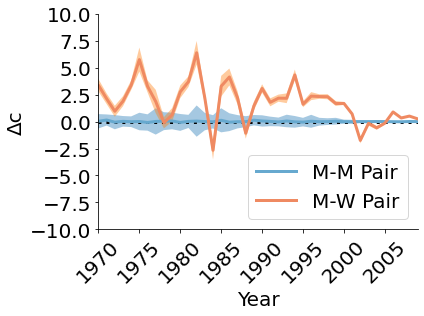

In [31]:
# Creating a year vs. centrality difference plot, separated by gender

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Equilibrium line
plt.axhline(y=0, color='black', linestyle='dotted', lw=3)

# Plotting M-M pairs
plt.plot(mm_ms.lateryear,mm_ms.avg,"-",label="M-M Pair",
         color='#67a9cf', lw=3)

# shading the SD area (M-M)
X  = np.linspace(min(mm_ms.lateryear),max(mm_ms.lateryear),mm_ms.lateryear.nunique())
plt.fill_between(X,
                 mm_ms.avg + mm_ms.sd,
                 mm_ms.avg - mm_ms.sd,
                 color='C0',alpha=.4,edgecolor="none")

# Plotting M-F pairs
plt.plot(mf_ms.lateryear,mf_ms.countd['mean'],"-",label="M-W Pair",
         color='#ef8a62', lw=3)

# shading the SE area (M-F)
plt.fill_between(X,
                 mf_ms.countd['mean'] + mf_ms['sem'],
                 mf_ms.countd['mean'] - mf_ms['sem'],
                 color='C1',alpha=.4,edgecolor="none")

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.xlabel("Year",fontsize=20)
plt.ylabel("\u0394c",fontsize=20)
plt.xlim(xmin=1970, xmax=2009)
plt.ylim(ymin=-10, ymax=10)

plt.legend(loc='lower right', fontsize=20)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/mm_mf_cdiff.pdf")

### Year difference vs. Centrality difference visualization by PACS

In [127]:
# Separate into 4 quadrants depending on count difference and year difference

N = 9  # subfield
sdoi = primdata[primdata[f'pacs{N}0'] == 1].doi

cy_mw = sim_mf.copy()
print(len(cy_mw))
cy_mw = cy_mw[cy_mw['qval'] < p]  # apply threshold
print(len(cy_mw))
cy_mw = cy_mw[(cy_mw.paper1.isin(sdoi)) & (cy_mw.paper2.isin(sdoi))
             ].reset_index(drop=True)  # apply subfield
print(len(cy_mw))

quad1 = cy_mw[(cy_mw.countd > 0) & (cy_mw.yeard > 0)]
quad2 = cy_mw[(cy_mw.countd > 0) & (cy_mw.yeard < 0)]
quad3 = cy_mw[(cy_mw.countd < 0) & (cy_mw.yeard < 0)]
quad4 = cy_mw[(cy_mw.countd < 0) & (cy_mw.yeard > 0)]

14490273
1057275
28262


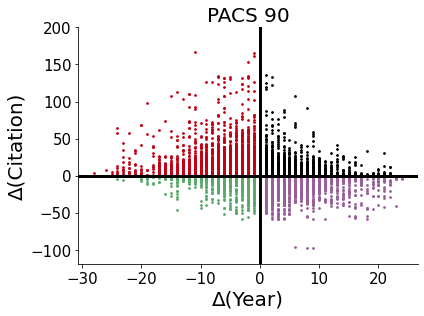

In [129]:
# build scatterplots

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Create year difference vs. count difference scatterplot
plt.title(f"PACS {N}0", fontsize=20)
plt.scatter(quad1.yeard, quad1.countd, s=3, c='#000000')
plt.scatter(quad2.yeard, quad2.countd, s=3, c='#c20114')
plt.scatter(quad3.yeard, quad3.countd, s=3, c='#59a96a')
plt.scatter(quad4.yeard, quad4.countd, s=3, c='#985f99')
plt.axhline(y=0, linewidth=0.5, c='k', lw=3)
plt.axvline(x=0, linewidth=0.5, c='k', lw=3)
plt.xlabel("\u0394(Year)", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)
plt.ylim(ymax=200)
# plt.xlim(xmin=-25, xmax=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/SI_Fig_6_PACS{N}0.pdf")